## Processing with RN data obtained from forest sites

# Load all data from .xlsx file

In [1]:
# Import main libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap

In [2]:
# Block warnings messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load biomass dataset
site_data = './RN_sites_data_2024_N186pcs.xlsx'
df = pd.read_excel(site_data, sheet_name='RN_filtration_data')
df.head()

,Ідентифікатор,Site #,Species,Species_ID,Ntrees at site,% composition,D_cm,H_m,G_m2_ha,N_ha,...,T_ag_Cs,ln_T_ag_Cs,T_ag_Sr,ln_T_ag_Sr,AEDR_count,AEDR_mean,AEDR_median,AEDR_std,Distance_km,Azimuth
0,81,001_2021,Pine,0,23,100.000000,26.060965,25.423284,49.081648,920,...,0.792857,-0.232112,8.990000,2.196113,26,3.524231,3.530,0.235489,5.926403,249
1,219,002_2021,Pine,0,60,90.178571,4.303100,4.705979,8.731641,6000,...,1.565517,0.448216,24.191919,3.186019,15,3.830667,3.780,0.166272,6.018960,249
2,224,003_2021,Pine,0,44,100.000000,28.142898,27.556869,54.703060,880,...,0.431579,-0.840305,6.800000,1.916923,28,0.483571,0.475,0.068931,13.046428,189
3,228,004_2021,Pine,0,23,100.000000,14.953551,8.506028,40.420188,2300,...,0.123529,-2.091276,2.460000,0.900161,20,0.364500,0.365,0.029576,12.741627,189
4,232,005_2021,Pine,0,26,100.000000,7.208435,3.425669,2.120687,520,...,0.221212,-1.508633,6.629225,1.891488,18,0.333333,0.345,0.036515,12.893213,189


# List of all parameters for est. of bioproductivity and RN content
"""

All parameters:
'Species', 'Species_ID', '% composition', 'D_cm', 'H_m', 'G_m2_ha',
                                    'Origin', 'Origin_ID','A_year', 'D_live_cm', 'H_live_m', 'G_live_m2_ha',
                                    'F_Soil_ID', 'M_Soil', 'AEDR_mean', 'Distance_km', 'Azimuth',
                                    'Cs_2021_kBq_m', 'Sr_2021_kBq_m', 'ln_A_Cs', 'ln_A_Sr', 
                                    'T_ag_Cs', 'ln_T_ag_Cs', 'T_ag_Sr', 'ln_T_ag_Sr'
"""

In [4]:
# Selecting main working parameters
select = pd.DataFrame(df, columns=['Species', 'Species_ID', '% composition', 'D_cm', 'H_m', 'G_m2_ha',
                                    'Origin', 'Origin_ID','A_year',
                                    'F_Soil_ID', 'M_Soil', 'AEDR_mean', 'Distance_km', 'Azimuth',
                                    'Cs_2021_kBq_m', 'Sr_2021_kBq_m', 'ln_A_Cs', 'ln_A_Sr', 
                                    'ln_T_ag_Cs', 'ln_T_ag_Sr'])
            
'''
In "Species_ID" column: "0" is Pine, "1" is Spruce, "2" is Birch, "3" is Alder, "4" is Aspen, "5" is Oak
In "Origin_ID" column: "0.0" is nutural stand, "1.0" is artificial stand
'''

# Show the first five columns
select.head()

,Species,Species_ID,% composition,D_cm,H_m,G_m2_ha,Origin,Origin_ID,A_year,F_Soil_ID,M_Soil,AEDR_mean,Distance_km,Azimuth,Cs_2021_kBq_m,Sr_2021_kBq_m,ln_A_Cs,ln_A_Sr,ln_T_ag_Cs,ln_T_ag_Sr
0,Pine,0,100.000000,26.060965,25.423284,49.081648,a,1,68,1,2,3.524231,5.926403,249,2800.0,1000.000000,7.705262,9.103868,-0.232112,2.196113
1,Pine,0,90.178571,4.303100,4.705979,8.731641,n,0,15,1,2,3.830667,6.018960,249,2900.0,990.000000,8.420682,10.083724,0.448216,3.186019
2,Pine,0,100.000000,28.142898,27.556869,54.703060,n,0,69,1,2,0.483571,13.046428,189,380.0,90.000000,5.099866,6.416732,-0.840305,1.916923
3,Pine,0,100.000000,14.953551,8.506028,40.420188,n,0,15,2,2,0.364500,12.741627,189,340.0,150.000000,3.737670,5.910797,-2.091276,0.900161
4,Pine,0,100.000000,7.208435,3.425669,2.120687,n,0,10,2,2,0.333333,12.893213,189,330.0,69.993095,4.290459,6.139885,-1.508633,1.891488


# Pre-analysis of parameters

In [5]:
# Information on all columns of data frame
select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Species        186 non-null    object 
 1   Species_ID     186 non-null    int64  
 2   % composition  186 non-null    float64
 3   D_cm           186 non-null    float64
 4   H_m            186 non-null    float64
 5   G_m2_ha        186 non-null    float64
 6   Origin         186 non-null    object 
 7   Origin_ID      186 non-null    int64  
 8   A_year         186 non-null    int64  
 9   F_Soil_ID      186 non-null    int64  
 10  M_Soil         186 non-null    int64  
 11  AEDR_mean      186 non-null    float64
 12  Distance_km    186 non-null    float64
 13  Azimuth        186 non-null    int64  
 14  Cs_2021_kBq_m  186 non-null    float64
 15  Sr_2021_kBq_m  186 non-null    float64
 16  ln_A_Cs        186 non-null    float64
 17  ln_A_Sr        186 non-null    float64
 18  ln_T_ag_Cs

In [6]:
# Discribe statistic of forest sites by species and origin
df.groupby(["Species"])["ln_A_Cs", "ln_A_Sr"].describe()

ln_A_Cs                                                              \
          count      mean       std       min       25%       50%       75%   
Species                                                                       
Alder      11.0  6.010710  1.519525  3.295837  5.477504  6.040255  6.910817   
Aspen       4.0  5.217525  2.888420  2.995732  3.902453  4.204693  5.519765   
Birch      39.0  5.633488  2.218366  2.079442  3.546702  6.173786  7.222539   
Oak         4.0  8.379504  1.867135  6.040255  7.325281  8.650218  9.704441   
Pine      125.0  6.084783  1.985309  1.504077  4.290459  6.622736  7.377759   
Red oak     3.0  3.445685  0.588708  2.833213  3.164860  3.496508  3.751920   

                   ln_A_Sr                                                    \
               max   count      mean       std       min       25%       50%   
Species                                                                        
Alder     8.465900    11.0  5.776075  1.400557  4.094345  4.393228  6.265301   
Aspen     9.464983     4.0  7.397134  2.804999  5.209486  5.298279  6.599403   
Birch     9.648595    39.0  7.556268  2.244353  2.660260  5.586554  7.749322   
Oak      10.177324     4.0  8.599001  1.943299  6.565265  7.466129  8.352474   
Pine     10.468801   125.0  7.506498  1.895896  2.406945  6.242223  7.595890   
Red oak   4.007333     3.0  4.697638  0.334751  4.418841  4.512005  4.605170   

                              
              75%        max  
Species                       
Alder    7.074686   7.630461  
Aspen    8.698259  11.180246  
Birch    9.003289  11.957611  
Oak      9.485347  11.125791  
Pine     8.846497  12.687263  
Red oak  4.837037   5.068904

In [7]:
# Descriptive statistics of main parameters
select.describe()

,Species_ID,% composition,D_cm,H_m,G_m2_ha,Origin_ID,A_year,F_Soil_ID,M_Soil,AEDR_mean,Distance_km,Azimuth,Cs_2021_kBq_m,Sr_2021_kBq_m,ln_A_Cs,ln_A_Sr,ln_T_ag_Cs,ln_T_ag_Sr
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,0.870968,95.014120,17.901653,16.971973,30.609632,0.483871,47.607527,1.865591,2.150538,2.369516,14.616704,172.978495,2378.208631,679.692875,5.973908,7.390435,-0.652415,2.300919
std,1.381154,13.546690,8.809357,6.844253,16.112951,0.501089,24.545198,0.613540,0.631536,4.402832,12.614626,100.042475,4562.948448,1402.001816,2.060827,2.014692,1.261268,0.923235
min,0.000000,20.805369,1.914854,2.704460,0.259356,0.000000,10.000000,1.000000,0.000000,0.110000,3.998568,9.000000,22.000000,1.000000,1.504077,2.406945,-4.379730,-0.167054
25%,0.000000,97.576059,12.441149,12.212882,17.706915,0.000000,30.000000,1.000000,2.000000,0.463750,6.545377,56.000000,390.000000,31.990484,4.110874,5.817872,-1.314905,1.665460
50%,0.000000,100.000000,16.868445,17.598108,31.919881,0.000000,45.000000,2.000000,2.000000,0.749009,9.207206,189.000000,695.000000,200.000000,6.323452,7.362006,-0.494694,2.375670
75%,2.000000,100.000000,22.416417,21.617236,43.492865,1.000000,60.000000,2.000000,2.000000,2.328245,19.364657,260.750000,2300.000000,605.000000,7.350518,8.888615,0.300465,2.914472
max,5.000000,100.000000,52.228464,31.262764,66.922093,1.000000,150.000000,3.000000,4.000000,36.591739,57.286577,342.000000,35200.000000,10500.000000,10.468801,12.687263,1.645806,5.227895


# Selecting working columns for the XGBoost algorithms

In [8]:
# Choosing the predictor and independent variables
predictor = "ln_T_ag_Sr"
variables = ['Species_ID','D_cm', 'H_m', 'G_m2_ha', 'A_year',
    'Origin_ID', 'F_Soil_ID', 'M_Soil', 'Sr_2021_kBq_m', 'ln_A_Sr']


In [9]:
# Delete empty rows from the working column in a dataframe
nan_value = float("NaN")
select.replace("", nan_value, inplace=True)
select.dropna(subset = [predictor], inplace=True) # IMPOTANT - input name of column
print(select)

    Species  Species_ID  % composition       D_cm        H_m    G_m2_ha  \
0      Pine           0     100.000000  26.060965  25.423284  49.081648   
1      Pine           0      90.178571   4.303100   4.705979   8.731641   
2      Pine           0     100.000000  28.142898  27.556869  54.703060   
3      Pine           0     100.000000  14.953551   8.506028  40.420188   
4      Pine           0     100.000000   7.208435   3.425669   2.120687   
..      ...         ...            ...        ...        ...        ...   
181    Pine           0     100.000000  16.501647   8.581286   9.831136   
182   Birch           2     100.000000   7.912790  13.818368  19.279495   
183    Pine           0     100.000000  16.041613  17.515821  31.533411   
184    Pine           0      96.775081  14.946465  18.178975  44.220927   
185    Pine           0     100.000000  15.387224  17.673021  55.824342   

    Origin  Origin_ID  A_year  F_Soil_ID  M_Soil  AEDR_mean  Distance_km  \
0        a          1  

In [10]:
# We select independent variables and predicting parameter 
X = pd.DataFrame(select, columns=variables)
y = pd.DataFrame(select, columns=[predictor])

In [11]:
# Columns in "X" data collections
X.head()

,Species_ID,D_cm,H_m,G_m2_ha,A_year,Origin_ID,F_Soil_ID,M_Soil,Sr_2021_kBq_m,ln_A_Sr
0,0,26.060965,25.423284,49.081648,68,1,1,2,1000.000000,9.103868
1,0,4.303100,4.705979,8.731641,15,0,1,2,990.000000,10.083724
2,0,28.142898,27.556869,54.703060,69,0,1,2,90.000000,6.416732
3,0,14.953551,8.506028,40.420188,15,0,2,2,150.000000,5.910797
4,0,7.208435,3.425669,2.120687,10,0,2,2,69.993095,6.139885


In [12]:
# Columns in "y" data collections
y.head()

,ln_T_ag_Sr
0,2.196113
1,3.186019
2,1.916923
3,0.900161
4,1.891488


In [13]:
#  Importing the main library for building model and its analysis
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification

# Add optimal hyperparameters for XGBoost model

In [14]:
# Hyperparameters data for the next step/stage
p1 = 0.7327675639923839                   # colsample_bytree
print('Colsample_bytree: ' + str(p1))

p2 = 0.04558812083388075                  # gamma
print('Gamma: ' + str(p2))

p3 = 0.10198012556475948                  # learning_rate
print('Learning_rate: ' + str(p3))

p4 = 2                                    # max_depth
print('Max_depth: ' + str(p4))

p5 = 79                                   # n_estimators
print('N_estimators: ' + str(p5))

p6 = 0.811521748868657                    # subsample
print('Subsample: ' + str(p6))

Colsample_bytree: 0.7327675639923839
Gamma: 0.04558812083388075
Learning_rate: 0.10198012556475948
Max_depth: 2
N_estimators: 79
Subsample: 0.811521748868657


# Estimation of predictive quality to basic XGBoost models using Loops

In [15]:
# Aggregate parameters
aggr_y=[]
aggr_y_pred=[]

aggr_optimal_n=[]
aggr_bias=[]
aggr_rel_bias=[]
aggr_rmse=[]
aggr_rel_rmse=[]
aggr_mse=[]
aggr_R_square=[]

exp_aggr_optimal_n=[]
exp_aggr_bias=[]
exp_aggr_rel_bias=[]
exp_aggr_rmse=[]
exp_aggr_rel_rmse=[]
exp_aggr_mse=[]
exp_aggr_R_square=[]

# Body loop
for i in range(200):
    
    # Generate test and training samples
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    #TYPING PARAMETERS
    sort_ln_A_Sr, sort_Sr_2021_kBq_m = pd.DataFrame(X_test[['ln_A_Sr', 'Sr_2021_kBq_m']]).T.values
    X_train = X_train.drop(columns=['ln_A_Sr', 'Sr_2021_kBq_m'])
    X_test = X_test.drop(columns=['ln_A_Sr', 'Sr_2021_kBq_m'])  
    
    # Implementation of the scikit-learn API for XGBoost regression
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=p1, gamma=p2, learning_rate=p3, 
                          max_depth=p4, n_estimators=p5, subsample=p6, eval_metric=["rmse"])
    
    # Fitting the model 
    xgb_model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_train, y_train), (X_test, y_test)])
    
    # learning dynamics
    y_pred = xgb_model.predict(X_test, ntree_limit=xgb_model.best_ntree_limit)
    
    # Iteration with the best result
    optimal_n= xgb_model.best_ntree_limit-1
    
    #TYPING PARAMETERS    
    y_test = pd.DataFrame(sort_ln_A_Sr, columns =["ln_A_Sr"], index=y_test.index)
    y_pred = np.log(np.exp(y_pred)*sort_Sr_2021_kBq_m)
    
    #exp_y_train = np.exp(y_train)
    exp_y_test = np.exp(y_test)
    exp_y_pred = np.exp(y_pred)
    
    # Convert data to 'array' type
    conv_y_pred = pd.DataFrame(y_pred) # Double transformation
    y_pred2 = conv_y_pred.values
    y_test2 = y_test.values
    
    exp_y_pred2 = np.exp(y_pred2)
    exp_y_test2 = np.exp(y_test2)
    
    # Intermediate results
    n_sample = len(y_pred2)
    y_mean_sample = y_test.sum() / n_sample
    
    exp_y_mean_sample = exp_y_test.sum() / n_sample
    
    # Calculation of bias
    diff = y_pred2 - y_test2
    bias = diff.sum()/n_sample
    rel_bias = bias/y_mean_sample*100
    
    exp_diff = exp_y_pred2 - exp_y_test2
    exp_bias = exp_diff.sum()/n_sample
    exp_rel_bias = exp_bias/exp_y_mean_sample*100
    
    # Calculation of RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rel_rmse = rmse/y_mean_sample*100 
    
    exp_rmse = np.sqrt(mean_squared_error(exp_y_test, exp_y_pred))
    exp_rel_rmse = exp_rmse/exp_y_mean_sample*100 
    
    # Calculation of MSE
    mse = mean_squared_error(y_test, y_pred)   
    
    exp_mse = mean_squared_error(exp_y_test, exp_y_pred)
    
    # Calculation of Square R
    diff_with_mean = []
    exp_diff_with_mean = []
    
    for i in range(n_sample):
        interm = y_test2[i] - y_mean_sample
        diff_with_mean.append(interm**2)

    RSS = np.sum((y_test2 - y_pred2)**2)
    TSS = (np.sum(diff_with_mean))
    R_square = 1 - (RSS / TSS)
    
    for i in range(n_sample):
        exp_interm = exp_y_test2[i] - exp_y_mean_sample
        exp_diff_with_mean.append(exp_interm**2)

    exp_RSS = np.sum((exp_y_test2 - exp_y_pred2)**2)
    exp_TSS = np.sum(exp_diff_with_mean)
    
    exp_R_square = 1 - (exp_RSS / exp_TSS)
    
    #Add values to lists
    aggr_y.append(y_test)
    aggr_y_pred.append(conv_y_pred)    
    
    aggr_optimal_n.append(optimal_n)
    aggr_bias.append(bias)
    aggr_rel_bias.append(rel_bias)
    aggr_rmse.append(rmse)
    aggr_rel_rmse.append(rel_rmse)
    aggr_mse.append(mse)
    aggr_R_square.append(R_square)
    
    exp_aggr_bias.append(exp_bias)
    exp_aggr_rel_bias.append(exp_rel_bias)
    exp_aggr_rmse.append(exp_rmse)
    exp_aggr_rel_rmse.append(exp_rel_rmse)
    exp_aggr_mse.append(exp_mse)
    exp_aggr_R_square.append(exp_R_square)
    
# Intermedia data to calculate CI
n_train = len(y_train)
n_test = len(y_test)

[0]	validation_0-rmse:1.78420	validation_1-rmse:2.10318
[1]	validation_0-rmse:1.63367	validation_1-rmse:1.94677
[2]	validation_0-rmse:1.51003	validation_1-rmse:1.82410
[3]	validation_0-rmse:1.39390	validation_1-rmse:1.69906
[4]	validation_0-rmse:1.29145	validation_1-rmse:1.59437
[5]	validation_0-rmse:1.20016	validation_1-rmse:1.50480
[6]	validation_0-rmse:1.12303	validation_1-rmse:1.42178
[7]	validation_0-rmse:1.04964	validation_1-rmse:1.34017
[8]	validation_0-rmse:0.98766	validation_1-rmse:1.27695
[9]	validation_0-rmse:0.93572	validation_1-rmse:1.22141
[10]	validation_0-rmse:0.88893	validation_1-rmse:1.17075
[11]	validation_0-rmse:0.84864	validation_1-rmse:1.12004
[12]	validation_0-rmse:0.81211	validation_1-rmse:1.08710
[13]	validation_0-rmse:0.78274	validation_1-rmse:1.06324
[14]	validation_0-rmse:0.75774	validation_1-rmse:1.02898
[15]	validation_0-rmse:0.73884	validation_1-rmse:1.00159
[16]	validation_0-rmse:0.71886	validation_1-rmse:0.98718
[17]	validation_0-rmse:0.70326	validation

# Create plot with predicted values for test samples (after 200 iteration)

In [16]:
# CHANGE PREDICTOR NAME 
predictor = "ln_A_Sr"

# Preprocessing
pd_aggr_y = pd.concat(aggr_y, join="inner")
pd_aggr_y['Obs'] = pd_aggr_y.index

pd_aggr_y_pred = pd.concat(aggr_y_pred, join="inner")

results_y = pd.concat([pd_aggr_y.reset_index(), pd_aggr_y_pred.reset_index()], axis=1)

n_all_y = len(results_y['Obs'])

stat_y = results_y.groupby(['Obs'])[predictor, 0].describe(percentiles=[.16, .5, .84])

l_sd_y_pred = stat_y[0]['50%'] - stat_y[0]['16%']
t_sd_y_pred = stat_y[0]['84%'] - stat_y[0]['50%']

n_stat_y = len(stat_y[0]['50%'])

In [17]:
"""
Assessment of linear approximation between observations and 
predict values and estimation of parameters uncertainties for this regression
"""
# Load libraries elements
from scipy.optimize import curve_fit   
from scipy import stats

# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

In [18]:
# Convert input data
x_test_conv = np.array(results_y[predictor])
x_test_convert = np.array([None]*n_all_y)
for i in range(n_all_y):
    x_test_convert[i] = np.float64(x_test_conv[i])

x_plot = x_test_convert
y_plot = results_y[0].to_list()
n = n_all_y

# Function for fitting a linear curve and estimating its parameters
def f(x_plot, a0, a1):
    return a0 + a1 * x_plot

popt, pcov = curve_fit(f, x_plot, y_plot)

R^2: 0.869
Uncertainty
a0: 0.49+/-0.221
a1: 0.928+/-0.028


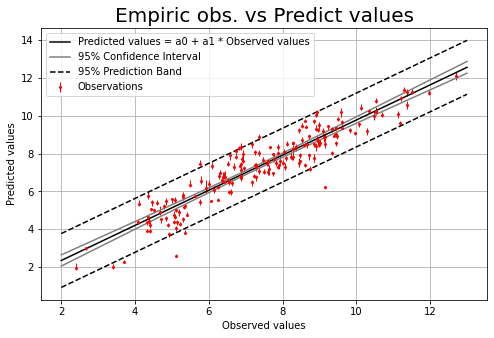

In [19]:
# Building linear a graph and calculation uncertainties

# retrieve parameter values
a0 = popt[0]
a1 = popt[1]

# compute r^2
r2 = 1.0-(sum((y_plot-f(x_plot, a0, a1)) ** 2)/((n - 1.0)*np.var(y_plot, ddof = 1)))
print(f'R^2: {r2:.3f}')

# calculate parameter confidence interval
a0, a1 = unc.correlated_values(popt, pcov)
index_a0 = str(a0).find('+/-')
index_a1 = str(a1).find('+/-')
am_a0 = str(a0)[0:index_a0]
ci_a0 = str(a0)[index_a0+3:]
am_a1 = str(a1)[0:index_a1]
ci_a1 = str(a1)[index_a1+3:]

print('Uncertainty')
print(f'a0: {am_a0}+/-{round(float(ci_a0)*(n_all_y/n_stat_y)**0.5, 3)}')
print(f'a1: {am_a1}+/-{round(float(ci_a1)*(n_all_y/n_stat_y)**0.5, 3)}')

# plot data
plt.figure(figsize =(8, 5))
plt.errorbar(stat_y[predictor]['mean'], stat_y[0]['50%'], yerr=[list(l_sd_y_pred), list(t_sd_y_pred)], c = 'red', fmt='o', lw=1, ms=2, label='Observations')
plt.yscale('linear')

# calculate regression confidence interval
px = np.linspace(2, 13, 100)
py = a0 + a1 * px
nom = unp.nominal_values(py)
std = unp.std_devs(py)

# estimation uncertenlies intervals
def predband(x_plot, xd, yd, p, func, conf=0.95):
    # x_plot = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x_plot - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x_plot, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

lpb, upb = predband(px, x_plot, y_plot, popt, f, conf=0.95)

# plot the regression
plt.plot(px, nom, c='black', label='Predicted values = a0 + a1 * Observed values')

# uncertainty lines (95% confidence)
plt.plot(px, nom - 1.96 * std * (n_all_y**0.5)/(n_stat_y**0.5), c='gray',\
         label='95% Confidence Interval')
plt.plot(px, nom + 1.96 * std * (n_all_y**0.5)/(n_stat_y**0.5), c='gray')

# prediction band (95% confidence)
plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.ylabel('Predicted values')
plt.xlabel('Observed values')
plt.grid(True)
plt.legend(loc='best')
plt.title('Empiric obs. vs Predict values', fontsize=20, color="black")
plt.show()

# Uncertainty parameters and confidence intervals

In [20]:
# Intermedia ratio for calculation CI
CIR = 2/((n_test + n_train)/n_test)**0.5

In [21]:
# Aggregate stat
# optimal number of iterations
aggr_optimal_n_mean = np.mean(aggr_optimal_n)
aggr_optimal_n_Q025 = np.quantile(aggr_optimal_n, 0.025)
aggr_optimal_n_Q16 = np.quantile(aggr_optimal_n, 0.16)
aggr_optimal_n_Q50 = np.quantile(aggr_optimal_n, 0.50)
aggr_optimal_n_Q84 = np.quantile(aggr_optimal_n, 0.84)
aggr_optimal_n_Q975 = np.quantile(aggr_optimal_n, 0.975)

# bias
aggr_bias_mean = np.mean(aggr_bias)
aggr_bias_Q025 = np.quantile(aggr_bias, 0.025)
aggr_bias_Q16 = np.quantile(aggr_bias, 0.16)
aggr_bias_Q50 = np.quantile(aggr_bias, 0.50)
aggr_bias_Q84 = np.quantile(aggr_bias, 0.84)
aggr_bias_Q975 = np.quantile(aggr_bias, 0.975)

aggr_rel_bias_mean = np.mean(aggr_rel_bias)
aggr_rel_bias_Q025 = np.quantile(aggr_rel_bias, 0.025)
aggr_rel_bias_Q16 = np.quantile(aggr_rel_bias, 0.16)
aggr_rel_bias_Q50 = np.quantile(aggr_rel_bias, 0.50)
aggr_rel_bias_Q84 = np.quantile(aggr_rel_bias, 0.84)
aggr_rel_bias_Q975 = np.quantile(aggr_rel_bias, 0.975)

# RMSE
aggr_rmse_mean = np.mean(aggr_rmse)
aggr_rmse_Q025 = np.quantile(aggr_rmse, 0.025)
aggr_rmse_Q16 = np.quantile(aggr_rmse, 0.16)
aggr_rmse_Q50 = np.quantile(aggr_rmse, 0.50)
aggr_rmse_Q84 = np.quantile(aggr_rmse, 0.84)
aggr_rmse_Q975 = np.quantile(aggr_rmse, 0.975)

aggr_rel_rmse_mean = np.mean(aggr_rel_rmse)
aggr_rel_rmse_Q025 = np.quantile(aggr_rel_rmse, 0.025)
aggr_rel_rmse_Q16 = np.quantile(aggr_rel_rmse, 0.16)
aggr_rel_rmse_Q50 = np.quantile(aggr_rel_rmse, 0.50)
aggr_rel_rmse_Q84 = np.quantile(aggr_rel_rmse, 0.84)
aggr_rel_rmse_Q975 = np.quantile(aggr_rel_rmse, 0.975)

# MSE
aggr_mse_mean = np.mean(aggr_mse)
aggr_mse_Q025 = np.quantile(aggr_mse, 0.025)
aggr_mse_Q16 = np.quantile(aggr_mse, 0.16)
aggr_mse_Q50 = np.quantile(aggr_mse, 0.50)
aggr_mse_Q84 = np.quantile(aggr_mse, 0.84)
aggr_mse_Q975 = np.quantile(aggr_mse, 0.975)

# R-square
aggr_R_square_mean = np.mean(aggr_R_square)
aggr_R_square_Q025 = np.quantile(aggr_R_square, 0.025)
aggr_R_square_Q16 = np.quantile(aggr_R_square, 0.16)
aggr_R_square_Q50 = np.quantile(aggr_R_square, 0.50)
aggr_R_square_Q84 = np.quantile(aggr_R_square, 0.84)
aggr_R_square_Q975 = np.quantile(aggr_R_square, 0.975)

# exp_bias
exp_aggr_bias_mean = np.mean(exp_aggr_bias)
exp_aggr_bias_Q025 = np.quantile(exp_aggr_bias, 0.025)
exp_aggr_bias_Q16 = np.quantile(exp_aggr_bias, 0.16)
exp_aggr_bias_Q50 = np.quantile(exp_aggr_bias, 0.50)
exp_aggr_bias_Q84 = np.quantile(exp_aggr_bias, 0.84)
exp_aggr_bias_Q975 = np.quantile(exp_aggr_bias, 0.975)

exp_aggr_rel_bias_mean = np.mean(exp_aggr_rel_bias)
exp_aggr_rel_bias_Q025 = np.quantile(exp_aggr_rel_bias, 0.025)
exp_aggr_rel_bias_Q16 = np.quantile(exp_aggr_rel_bias, 0.16)
exp_aggr_rel_bias_Q50 = np.quantile(exp_aggr_rel_bias, 0.50)
exp_aggr_rel_bias_Q84 = np.quantile(exp_aggr_rel_bias, 0.84)
exp_aggr_rel_bias_Q975 = np.quantile(exp_aggr_rel_bias, 0.975)

# exp_RMSE
exp_aggr_rmse_mean = np.mean(exp_aggr_rmse)
exp_aggr_rmse_Q025 = np.quantile(exp_aggr_rmse, 0.025)
exp_aggr_rmse_Q16 = np.quantile(exp_aggr_rmse, 0.16)
exp_aggr_rmse_Q50 = np.quantile(exp_aggr_rmse, 0.50)
exp_aggr_rmse_Q84 = np.quantile(exp_aggr_rmse, 0.84)
exp_aggr_rmse_Q975 = np.quantile(exp_aggr_rmse, 0.975)

exp_aggr_rel_rmse_mean = np.mean(exp_aggr_rel_rmse)
exp_aggr_rel_rmse_Q025 = np.quantile(exp_aggr_rel_rmse, 0.025)
exp_aggr_rel_rmse_Q16 = np.quantile(exp_aggr_rel_rmse, 0.16)
exp_aggr_rel_rmse_Q50 = np.quantile(exp_aggr_rel_rmse, 0.50)
exp_aggr_rel_rmse_Q84 = np.quantile(exp_aggr_rel_rmse, 0.84)
exp_aggr_rel_rmse_Q975 = np.quantile(exp_aggr_rel_rmse, 0.975)

# exp_MSE
exp_aggr_mse_mean = np.mean(exp_aggr_mse)
exp_aggr_mse_Q025 = np.quantile(exp_aggr_mse, 0.025)
exp_aggr_mse_Q16 = np.quantile(exp_aggr_mse, 0.16)
exp_aggr_mse_Q50 = np.quantile(exp_aggr_mse, 0.50)
exp_aggr_mse_Q84 = np.quantile(exp_aggr_mse, 0.84)
exp_aggr_mse_Q975 = np.quantile(exp_aggr_mse, 0.975)

# exp_R-square
exp_aggr_R_square_mean = np.mean(exp_aggr_R_square)
exp_aggr_R_square_Q025 = np.quantile(exp_aggr_R_square, 0.025)
exp_aggr_R_square_Q16 = np.quantile(exp_aggr_R_square, 0.16)
exp_aggr_R_square_Q50 = np.quantile(exp_aggr_R_square, 0.50)
exp_aggr_R_square_Q84 = np.quantile(exp_aggr_R_square, 0.84)
exp_aggr_R_square_Q975 = np.quantile(exp_aggr_R_square, 0.975)

In [22]:
# Output calculated stat
print("Logarithmically transformed predictive values:")
print(f"Aggregate optimal number of iterations statistic: \n mean: {round(aggr_optimal_n_mean, 3)}, median: {round(aggr_optimal_n_Q50, 3)},\n pred. interval (P(0.025)-P(0.975)): {round(aggr_optimal_n_Q025, 3)}-{round(aggr_optimal_n_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_optimal_n_Q50-((aggr_optimal_n_Q50-aggr_optimal_n_Q16)*CIR), 3)}-{round(aggr_optimal_n_Q50+((aggr_optimal_n_Q84-aggr_optimal_n_Q50)*CIR), 3)} \n***")
print(f"Aggregate bias statistic: \n mean: {round(aggr_bias_mean, 3)}, median: {round(aggr_bias_Q50, 3)},\n pred. interval (P(0.025)-P(0.975)): {round(aggr_bias_Q025, 3)}-{round(aggr_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_bias_Q50-((aggr_bias_Q50-aggr_bias_Q16)*CIR), 3)}-{round(aggr_bias_Q50+((aggr_bias_Q84-aggr_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE statistic: \n mean: {round(aggr_rmse_mean, 3)}, median: {round(aggr_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_rmse_Q025, 3)}-{round(aggr_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_rmse_Q50-((aggr_rmse_Q50-aggr_rmse_Q16)*CIR), 3)}-{round(aggr_rmse_Q50+((aggr_rmse_Q84-aggr_rmse_Q50)*CIR), 3)} \n***")
print(f"Aggregate MSE statistic: \n mean: {round(aggr_mse_mean, 3)}, median: {round(aggr_mse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_mse_Q025, 3)}-{round(aggr_mse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_mse_Q50-((aggr_mse_Q50-aggr_mse_Q16)*CIR), 3)}-{round(aggr_mse_Q50+((aggr_mse_Q84-aggr_mse_Q50)*CIR), 3)} \n***")
print(f"Aggregate R^2 statistic: \n mean: {round(aggr_R_square_mean, 3)}, median: {round(aggr_R_square_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_R_square_Q025, 3)}-{round(aggr_R_square_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_R_square_Q50-((aggr_R_square_Q50-aggr_R_square_Q16)*CIR), 3)}-{round(aggr_R_square_Q50+((aggr_R_square_Q84-aggr_R_square_Q50)*CIR), 3)} \n***")
print(f"Aggregate bias(%) statistic: \n mean: {round(aggr_rel_bias_mean, 3)}, median: {round(aggr_rel_bias_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_rel_bias_Q025, 3)}-{round(aggr_rel_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_rel_bias_Q50-((aggr_rel_bias_Q50-aggr_rel_bias_Q16)*CIR), 3)}-{round(aggr_rel_bias_Q50+((aggr_rel_bias_Q84-aggr_rel_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE(%) statistic: \n mean: {round(aggr_rel_rmse_mean, 3)}, median: {round(aggr_rel_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(aggr_rel_rmse_Q025, 3)}-{round(aggr_rel_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(aggr_rel_rmse_Q50-((aggr_rel_rmse_Q50-aggr_rel_rmse_Q16)*CIR), 3)}-{round(aggr_rel_rmse_Q50+((aggr_rel_rmse_Q84-aggr_rel_rmse_Q50)*CIR), 3)} \n***")

print("\nTransformed predictive values into the primary state:")
print(f"Aggregate bias statistic: \n mean: {round(exp_aggr_bias_mean, 3)}, median: {round(exp_aggr_bias_Q50, 3)},\n pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_bias_Q025, 3)}-{round(exp_aggr_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_bias_Q50-((exp_aggr_bias_Q50-exp_aggr_bias_Q16)*CIR), 3)}-{round(exp_aggr_bias_Q50+((exp_aggr_bias_Q84-exp_aggr_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE statistic: \n mean: {round(exp_aggr_rmse_mean, 3)}, median: {round(exp_aggr_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_rmse_Q025, 3)}-{round(exp_aggr_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_rmse_Q50-((exp_aggr_rmse_Q50-exp_aggr_rmse_Q16)*CIR), 3)}-{round(exp_aggr_rmse_Q50+((exp_aggr_rmse_Q84-exp_aggr_rmse_Q50)*CIR), 3)} \n***")
print(f"Aggregate MSE statistic: \n mean: {round(exp_aggr_mse_mean, 3)}, median: {round(exp_aggr_mse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_mse_Q025, 3)}-{round(exp_aggr_mse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_mse_Q50-((exp_aggr_mse_Q50-exp_aggr_mse_Q16)*CIR), 3)}-{round(exp_aggr_mse_Q50+((exp_aggr_mse_Q84-exp_aggr_mse_Q50)*CIR), 3)} \n***")
print(f"Aggregate R^2 statistic: \n mean: {round(exp_aggr_R_square_mean, 3)}, median: {round(exp_aggr_R_square_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_R_square_Q025, 3)}-{round(exp_aggr_R_square_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_R_square_Q50-((exp_aggr_R_square_Q50-exp_aggr_R_square_Q16)*CIR), 3)}-{round(exp_aggr_R_square_Q50+((exp_aggr_R_square_Q84-exp_aggr_R_square_Q50)*CIR), 3)} \n***")
print(f"Aggregate bias(%) statistic: \n mean: {round(exp_aggr_rel_bias_mean, 3)}, median: {round(exp_aggr_rel_bias_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_rel_bias_Q025, 3)}-{round(exp_aggr_rel_bias_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_rel_bias_Q50-((exp_aggr_rel_bias_Q50-exp_aggr_rel_bias_Q16)*CIR), 3)}-{round(exp_aggr_rel_bias_Q50+((exp_aggr_rel_bias_Q84-exp_aggr_rel_bias_Q50)*CIR), 3)} \n***")
print(f"Aggregate RMSE(%) statistic: \n mean: {round(exp_aggr_rel_rmse_mean, 3)}, median: {round(exp_aggr_rel_rmse_Q50, 3)}, pred. interval (P(0.025)-P(0.975)): {round(exp_aggr_rel_rmse_Q025, 3)}-{round(exp_aggr_rel_rmse_Q975, 3)}, \n conf. interval (p-value=0.95): {round(exp_aggr_rel_rmse_Q50-((exp_aggr_rel_rmse_Q50-exp_aggr_rel_rmse_Q16)*CIR), 3)}-{round(exp_aggr_rel_rmse_Q50+((exp_aggr_rel_rmse_Q84-exp_aggr_rel_rmse_Q50)*CIR), 3)} \n***")

Logarithmically transformed predictive values:
Aggregate optimal number of iterations statistic: 
 mean: 47.693, median: 47.5,
 pred. interval (P(0.025)-P(0.975)): 19.725-78.0, 
 conf. interval (p-value=0.95): 27.16-69.648 
***
Aggregate bias statistic: 
 mean: -0.036, median: -0.031,
 pred. interval (P(0.025)-P(0.975)): -0.275-0.189, 
 conf. interval (p-value=0.95): -0.135-0.063 
***
Aggregate RMSE statistic: 
 mean: 0.735, median: 0.723, pred. interval (P(0.025)-P(0.975)): 0.571-0.925, 
 conf. interval (p-value=0.95): 0.658-0.817 
***
Aggregate MSE statistic: 
 mean: 0.549, median: 0.523, pred. interval (P(0.025)-P(0.975)): 0.327-0.856, 
 conf. interval (p-value=0.95): 0.433-0.668 
***
Aggregate R^2 statistic: 
 mean: 0.857, median: 0.871, pred. interval (P(0.025)-P(0.975)): 0.753-0.916, 
 conf. interval (p-value=0.95): 0.818-0.897 
***
Aggregate bias(%) statistic: 
 mean: -0.482, median: -0.418, pred. interval (P(0.025)-P(0.975)): -3.793-2.638, 
 conf. interval (p-value=0.95): -1.90

# Analysis of residuals distributions dependents on empirical values of predicted parameter

Text(0.5, 1.0, 'In typical state')

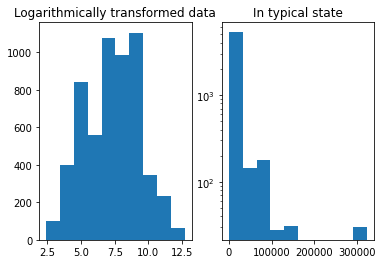

In [23]:
# Preprocessing
results_y['T_exp_empiric'] = np.exp(results_y[predictor])
results_y['T_exp_pred'] = np.exp(results_y[0])

results_y['ln_residuals'] = results_y[predictor] - results_y[0]
results_y['T_exp_residuals'] = results_y['T_exp_empiric'] - results_y['T_exp_pred']
results_y['ln_residuals_%'] =  results_y['ln_residuals'] / results_y[predictor] * 100
results_y['T_exp_residuals_%'] = results_y['T_exp_residuals'] / results_y['T_exp_empiric'] * 100

# plt.hist(results_y[predictor])
# plt.hist(results_y[predictor])
fig, axs = plt.subplots(1, 2)
axs[0].hist(results_y[predictor])
axs[0].set_title('Logarithmically transformed data')
axs[1].hist(results_y['T_exp_empiric'], log=True)
axs[1].set_title('In typical state')
# plt.show() 

In [24]:
# INPORTANT  - added your intervals
ln_intervals = pd.cut(results_y[predictor], [2, 4, 6, 8, 10, 12])
T_exp_intervals = pd.cut(results_y['T_exp_empiric'], [0, 500, 1000, 5000, 10000, 500000])

ln_grouped = results_y.groupby(ln_intervals)
T_exp_grouped = results_y.groupby(T_exp_intervals) 

max_obs_in_group = len(results_y)    
    
pre_ln = pd.DataFrame()
pre_T_exp = pd.DataFrame()
pre_rel_ln = pd.DataFrame()
pre_rel_T_exp = pd.DataFrame()

pre_ln = pre_ln.assign(row_number=range(max_obs_in_group))
pre_T_exp = pre_T_exp.assign(row_number=range(max_obs_in_group))
pre_rel_ln = pre_rel_ln.assign(row_number=range(max_obs_in_group))
pre_rel_T_exp = pre_rel_T_exp.assign(row_number=range(max_obs_in_group))

for i in range(len(list(ln_grouped))):
    pre_ln[list(ln_grouped)[i][0]] = pd.Series(list(ln_grouped)[i][1]['ln_residuals'])
    pre_rel_ln[list(ln_grouped)[i][0]] = pd.Series(list(ln_grouped)[i][1]['ln_residuals_%'])

for i in range(len(list(T_exp_grouped))):
    pre_T_exp[list(T_exp_grouped)[i][0]] = pd.Series(list(T_exp_grouped)[i][1]['T_exp_residuals'])
    pre_rel_T_exp[list(T_exp_grouped)[i][0]] = pd.Series(list(T_exp_grouped)[i][1]['T_exp_residuals_%'])

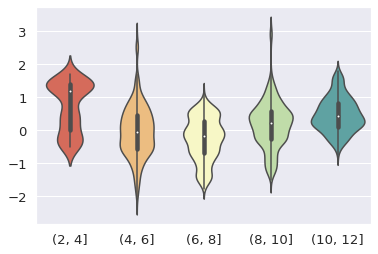

In [25]:
# Plots of residuals versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_ln[list(pre_ln.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

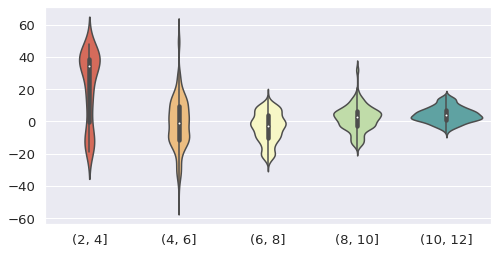

In [26]:
# Plots of relative residuals (in %) versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_rel_ln[(pre_rel_ln.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

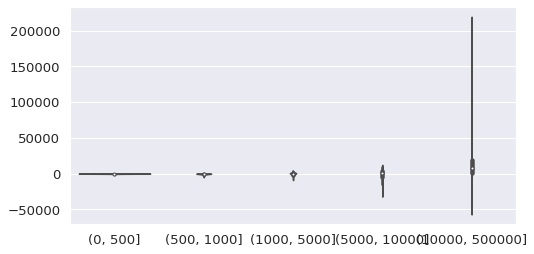

In [27]:
# Plots of residuals versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_T_exp[list(pre_T_exp.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()

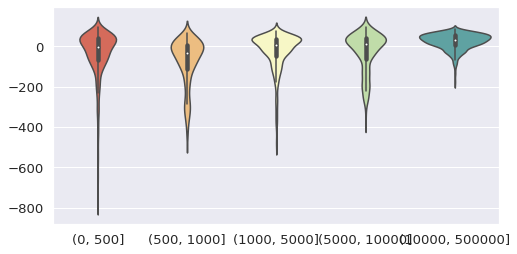

In [28]:
# Plots of relative residuals (in %) versus predicted values
sns.set(font_scale=1.2)
sns.violinplot(data=pre_rel_T_exp[(pre_rel_T_exp.columns)[1:]], inner="box", palette="Spectral")
sns.set(rc={'figure.figsize':(8,4)})
plt.show()